In [ ]:
pip install openseespy

## **Modeling this Turbine**
**65-kW Wind Turbine courtesy of UCSD**
<img src='Research\Turbine.PNG' width="300" height="300">

In [24]:
# following example on http://opensees.berkeley.edu/wiki/index.php/Elastic_Frame_Example
# running dynamic ground motion

%matplotlib notebook

# import OpenSees and libraries
from openseespy.opensees import *
from openseespy.postprocessing.Get_Rendering import *

# numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt
import pandas as pd
import csv

# system commands
import os, os.path
import glob
import shutil

# -------------------------------
#       Generate Model
# -------------------------------

# remove existing model
wipe()

# remove existing results
# explanation here: https://stackoverflow.com/a/31989328
def remove_thing(path):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)

def empty_directory(path):
    for i in glob.glob(os.path.join(path, '*')):
        remove_thing(i)

empty_directory('modes')
empty_directory('output')

# ---------------------------------------
#   Generate model and static analysis
# ---------------------------------------

# set modelbuilder
model('basic', '-ndm', 3, '-ndf', 6)

# units: in, kip, s
# dimensions
ft = 12.0
inch = 1.0
g = 386.1 #in/s^2
kip = 1.0
ksi = kip/(inch**2)
s = 1

# material properties
Es = 29000*ksi
Gs = 11500*ksi

# -------------------------------
#       Create Nodes
# -------------------------------
# command: node(nodeID, x-coord, y-coord, z-coord)
# command: node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
# Note: Ian Prowell Dissertation: Split into 30 beam-column elements

# specify number of elements of each portion of the tower
eldiv = 6

# Defining the first node
nodeTag = 1
node(nodeTag, 0.0, 0.0, 0.0)

# Heights of tower sections
hbot = 238.2*inch
hbottap = 74.8*inch
hmid = 237.2*inch
hmidtap = 74.8*inch
htop = 263*inch # to reach the top of the nacelle 238 og 

# Lower tower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = (hbot/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)
    
# Tapered lower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + (hbottap/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)

# Middle tower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + hbottap + (hmid/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)

# Tapered middle section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + hbottap + hmid + (hmidtap/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)
    
# Top tower section (Split into eldiv elements)
for j in range(eldiv):
    nodeTag += 1
    h = hbot + hbottap + hmid + hmidtap + (htop/eldiv)*(j + 1)
    node(nodeTag, 0.0, 0.0, h)
    
# restraints
# command: fix(nodeID, DOF1, DOF2, DOF3, DOF4, DOF5, DOF6) 0 = free, 1 = fixed
# Use a fixed connection for now
fix(1, 1, 1, 1, 1, 1, 1)

# geometric transformation for beam-columns
# command: geomTransf('Type', TransfTag)
# see https://opensees.berkeley.edu/wiki/index.php/Linear_Transformation 
geomTransf('PDelta', 1, 0, 1, 0) #columns

# -------------------------------
#       Define Elements
# -------------------------------

# initialize lists
D = [] # diameters in
A = [] # areas in^2
I = [] # area moment of inertia in^4
J = [] # polar moment of inertia in^4
dM = [] # distributed masses kip*s^2/in
V = [] # volumes in^3
H = [] # height of each element in
t = 0.21*inch # thickness is constant


# Determining the diameters, areas, area moment of inertias, and polar moments of each discretized tower segment
# diameters of tower
dbot = 78.7*inch
dmid = 62.9*inch
dtop = 47.2*inch

index = 0

# Lower tower section (Split into eldiv elemenets)
for j in range(eldiv):
    H.append(hbot/eldiv)
    D.append(dbot)
    A.append(((D[index])**2 - (D[index] - (2*t))**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1

# Tapered lower section (Split into eldiv elements)
for j in range(eldiv):
    H.append(hbottap/eldiv)
    d = ((j + 1)/(2*eldiv))*(dmid-dbot) + dbot # interpolating for the diameter based on eldiv
    D.append(d)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1

# Middle tower section (Split into eldiv elements)
for j in range(eldiv):
    H.append(hmid/eldiv)
    D.append(dmid)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1

# Tapered middle section (Split into eldiv elements)
for j in range(eldiv):
    H.append(hmidtap/eldiv)
    d = ((j + 1)/(2*eldiv))*(dtop-dmid) + dmid # interpolating for the diameter based on eldiv
    D.append(d)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1
    
# Top tower section
for j in range(eldiv):
    H.append(htop/eldiv)
    D.append(dtop)
    A.append(((D[index])**2 - (D[index] - 2*t)**2)*math.pi/4)
    I.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/64)
    J.append(((D[index])**4 - (D[index] - 2*t)**4)*math.pi/32)
    index += 1
    
# Determining volumes of tower segments
index = 0

# Lower tower section (Split into eldiv elemenets)
for j in range(eldiv):
    v = math.pi*(hbot/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
    V.append(v)
    index += 1
    
# Tapered lower section (Split into eldiv elements)
for j in range(eldiv):
    dlower = ((dmid-dbot)*j)/(eldiv) + dbot
    dhigher = ((dmid-dbot)*(j+1))/(eldiv) + dbot
    v = math.pi*(hbottap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 + (dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
    V.append(v)
    index += 1    

# Middle tower section (Split into eldiv elements)
for j in range(eldiv):
    v = math.pi*(hmid/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
    V.append(v)
    index += 1
    
# Tapered middle section (Split into eldiv elements)
for j in range(eldiv):
    dlower = ((dtop-dmid)*j)/(eldiv) + dmid
    dhigher = ((dtop-dmid)*(j+1))/(eldiv) + dmid
    v = math.pi*(hmidtap/eldiv)*((dlower**2 +dlower*dhigher + dhigher**2)-((dlower-2*t)**2 +(dlower-2*t)*(dhigher-2*t) + (dhigher-2*t)**2))/12
    V.append(v)
    index += 1    

# Top tower section (Split into eldiv elements)
for j in range(eldiv):
    v = math.pi*(htop/eldiv)*(D[index]**2 - (D[index]-2*t)**2)/4
    V.append(v)
    index += 1


mtotal = 14.101*kip/g
vtotal = sum(V)
htotal = hbot + hbottap + hmid + hmidtap + htop

# Determining distributed masses of tower segments
# Entire tower section (Split into 5*eldiv elemenets)
for j in range(len(H)):
    distm = (mtotal*V[j])/(vtotal*H[j]) # mass/height constant
    dM.append(distm)
    
# Defining the elements and determining areas, area moment of inertias, and polar inertias for each section
# Cylindrical sections => Ix = Iy 
# Cylindrical sections => J = Iz = 2*Ix = (D^4-(D-t)^4)*(pi/32) 

# Assigning element properties
# create elastic beam-column elements - 
# command: element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, G_mod, Jxx, Iy, Iz, transfTag, <'-mass', mass>, <'-cMass'>)
# define the columns  
for j in range(len(H)):
    element('elasticBeamColumn', j+1, j+1, j+2, A[j], Es, Gs, J[j], I[j], I[j], 1, '-mass', dM[j])

# Uncomment to see how the turbine twists
#node(nodeTag +1, 0.0, 10.0*ft, h)
#geomTransf('Linear', 2, 0, 0, 1) #columns
#element('elasticBeamColumn', len(H) + 1, len(H) + 1, len(H) + 2, A[len(H)-2], Es, Gs, J[len(H)-2], I[len(H)-2], I[len(H)-2], 2, '-mass', dM[len(H)-2])
    
# assign additional masses
# masses only act at nodes that have DoF
# command: mass(nodeID, dx, dy, dz, r@x, r@y, r@z)
# rotational inertia for a point mass: I = mr^2
whub = 9.4*kip
mhub = whub/g #kip*s^2/in
### to-do: the box is slightly higher than the last node of the tower, should we add another node? how would it be connected to the rest of the tower?
hhub = 888*inch # height of hub
#node(len(H) + 2, 0.0, 0.0, hhub) # CHANGE the top height it this is used
#rigidLink('beam', len(H)+1, len(H)+2)
mass(len(H) + 1, mhub, mhub, mhub, 0.0, 0.0, 0.0)

# -------------------------------
#       Set up Static analysis
# -------------------------------

# # create TimeSeries 
# timeSeries("Linear", 1)

# # create plain load pattern
# # command pattern('Plain', tag, timeSeriesTag)
# pattern('Plain', 1, 1)

# # Distributed element load of segments
# for j in range(len(H)-1):
#     eleLoad('-ele', j+1, j+1, j+2, '-type', '-beamUniform', -dM[j]*g, 0.0, 0.0)

# # Concentrated load of nacelle and hub
# load(len(H) + 1, 0.0, -whub, 0.0, 0.0, 0.0, 0.0)

# # ------------------------------
# # Start of analysis generation
# # ------------------------------

# # create system of equation (SOE)
# system("BandSPD")
# # create DOF numberer
# numberer("RCM")
# # create constraint handler
# constraints("Plain")
# # create integration scheme (steps of 1.0)
# integrator("LoadControl", 1.0)
# # create solution algorithm
# algorithm("Linear")
# # create analysis object
# analysis("Static")
# # perform the analysis
# analyze(1)


# # set gravity loads constant and reset time
# loadConst('-time', 0.0)


# --------------------------------
#       Perform eigen analysis
# --------------------------------

numEigen = 30
lameigenValues = eigen(numEigen)

wn = [i ** 0.5 for i in lameigenValues]
fn = [i / (2*math.pi) for i in wn]

print("Natural Frequencies:", fn, "Hz")

# compute the modal properties
#modalProperties("-print", "-file", "ModalReport.txt", "-unorm")

# -------------------------------------------
#       Plotting Structure and Modeshapes
# -------------------------------------------

# Display the active model with node and element tags
#plot_model("nodes","elements")

#plot_modeshape(1, 50)
#plot_modeshape(3, 50)
#plot_modeshape(6, 50)


# ----------------------------------
#       Define Sinusoidal Loading
# ----------------------------------

# Define parameters of the Sinusoidal Loading

T = 50 #Define how long the loading should go for
dt = 0.01 # Define the time step for input ground motion
tsteps = range(int((T/dt)+1))

# Define range of forcing frequency f (Hz)
f1 = 1/s
f2 = 15/s
df = 0.05 # Define discretization of forcing frequencies 
fsteps = range(int((f2-f1)/df))


t = [] # Define time list
for i in (tsteps):
    t.append(dt*i)

dfddug = pd.DataFrame(index=[t]) # Define dataframe with all ddug data
    

    
# -------------------------------
#       Set up Dynamic analysis
# -------------------------------


f = []
peakVx = []
peakVy = []
peakMx = []
peakMy = []
dfVx = pd.DataFrame(index=[t]) # Define dataframe with all Base Shear x data
dfVy = pd.DataFrame(index=[t]) # Define dataframe with all Base Shear y data
dfMx = pd.DataFrame(index=[t]) # Define dataframe with all Overturning Moment about the x axis data
dfMy = pd.DataFrame(index=[t]) # Define dataframe with all Overturning Moment about the y axis data

# Define a function to return the maximum value of the steady state response
def eleMax(items, start = 0, end=None):
    return abs(max(items[start:end], key=abs))

# set the rayleigh damping factors for nodes & elements
rayleigh(0.0, 0.0, 0.0, 2*0.005/wn[0])

# Looping for each frequency
for i in fsteps:
    wipeAnalysis() # Wipe any previous pattern
    constraints('Plain')  			# how it handles boundary conditions
    numberer('Plain')
    system('BandGeneral')		    # how to store and solve the system of equations in the analysis
    algorithm('Newton')                 # use Newton-Raphson for linear analysis
    integrator('Newmark', 0.5, 0.25)        # create integration scheme, Newmark with alpha = 0.5, beta = 0.25
    analysis('Transient')      	    # define type of analysis static or transient

    # Create the convergence test, the norm of the residual with a tolerance of
    # 1e-12 and a max number of iterations of 10
    test('NormDispIncr', 1.0e-12,  10 )

# # # Run each ground motion per each frequency wf and extract the maximum moment per each sinusoidal ground motion
    f.append(f1 + (df*i)) # Keeping track of the frequencies
    Vx = [] # Resetting each vector for each frequency
    Vy = []
    Mx = []
    My = []
    setTime(0) # Reset time
    time = []
    
    # Setting up variables for the transient analysis
    tCurrent = getTime()
    tFinal = T
    ok = 0
    # Getting the correct ground motion per frequency step
    timeSeries('Trig', i+1, 0, T, 1/f[i], '-factor', g) 
    # patternTag, direction  accelTag
    pattern('UniformExcitation', i+1, 1, '-accel', i+1) # x direction

    # Perform the transient analysis
    while ok == 0 and tCurrent < tFinal:
        ok = analyze(1, dt)
        if ok != 0:
            print('WARNING' + str(tCurrent) + 'w' + str(i))
        # if the analysis fails try initial tangent iteration
            print("regular newton failed .. let's try an initial stiffness for this step")
            test('NormDispIncr', 1.0e-12,  100, 0)
            algorithm('ModifiedNewton', '-initial')
            ok = analyze(1, dt)
            if ok == 0:
                print("that worked .. back to regular newton")
            test('NormDispIncr', 1.0e-12,  10 )
            algorithm('Newton')
        # Store element forces per time step 
        tCurrent = getTime()
        time.append(tCurrent)     
        Vx.append(eleForce(1, 1)) # Vx
        Vy.append(eleForce(1, 2)) # Vy
        Mx.append(eleForce(1, 4)) # Mx
        My.append(eleForce(1, 5)) # My
    # Post-processing
    maxVx = eleMax(Vx, int((T/dt)+1) - 20)
    peakVx.append(maxVx)
    #peakVx.append(abs(max(Vx, key=abs)))
    peakVy.append(abs(max(Vy, key=abs)))
    peakMx.append(abs(max(Mx, key=abs)))
    peakMy.append(abs(max(My, key=abs)))
    dfVx['w'+str(i)] = Vx
    dfVy['w'+str(i)] = Vy
    dfMx['w'+str(i)] = Mx
    dfMy['w'+str(i)] = My
    
dfVx.head(20)

Natural Frequencies: [1.7416607571903036, 1.7416607571903038, 12.931617421321738, 12.931617421321757, 31.418375759311626, 37.505328161085046, 37.5053281610852, 79.97732298602372, 79.9773229860238, 104.6375598026506, 133.1734638879497, 133.17346388794996, 196.81607870835458, 203.029757589956, 203.0297575899578, 286.6503681199756, 286.650368119977, 292.1269359117965, 381.9905462634204, 386.7368293026861, 386.7368293026865, 472.3499565287913, 503.8193891083723, 503.81938910837493, 568.2869993159867, 623.5401856468231, 623.5401856468255, 648.9158433117016, 729.0586013039621, 766.5852489920466] Hz


,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w270,w271,w272,w273,w274,w275,w276,w277,w278,w279
0.00,0.236124,3.254948,0.374110,3.726234,0.176884,4.233761,-0.192266,4.826414,-0.855803,5.575038,...,1341.530728,1334.720103,1347.359296,1340.920953,1353.229912,1347.136978,1359.140882,1353.369309,1365.090702,1359.618897
0.01,0.737027,5.509588,1.697964,7.042544,2.243828,8.709032,2.576224,10.583202,2.480091,12.790352,...,2230.657311,2231.153412,2244.622500,2245.291171,2258.599060,2259.430458,2272.585335,2273.570127,2286.579669,2287.709039
0.02,1.348747,7.863250,3.381607,10.702953,4.946951,13.793905,6.281837,17.234168,7.080820,21.201468,...,2858.454769,2865.897481,2872.539777,2879.815142,2886.471716,2893.591264,2900.249250,2907.222569,2913.870903,2920.705998
0.03,2.069207,10.346221,5.418119,14.734900,8.274768,19.511098,10.908041,24.794803,12.925030,30.813138,...,3087.723455,3096.880078,3093.879139,3102.588525,3099.711498,3108.000375,3105.222933,3113.114871,3110.415738,3117.931649
0.04,2.857129,12.947671,7.674884,19.038178,11.995448,25.661081,16.115132,32.955645,19.557110,41.194337,...,2908.094892,2912.931332,2903.543592,2907.918323,2898.701460,2902.643649,2893.578945,2897.115191,2888.186471,2891.341152
0.05,3.632002,15.601469,9.894305,23.370038,15.658341,31.806575,21.242706,41.066298,26.090730,51.461969,...,2401.246222,2399.428599,2389.643348,2387.670990,2378.056701,2375.946986,2366.502567,2364.272143,2354.997017,2352.661814
0.06,4.288267,18.047360,11.746967,27.230007,18.689155,37.184027,25.449884,48.076662,31.397243,60.254997,...,1680.849985,1673.432224,1668.774525,1661.646708,1657.112630,1650.269701,1645.873733,1639.311828,1635.066536,1628.782677
0.07,4.863244,20.190994,13.359919,30.598743,21.312310,41.855095,29.065565,54.134887,35.917656,67.812782,...,1129.249074,1120.039298,1124.649456,1116.010396,1120.647213,1112.549991,1117.229646,1109.647651,1114.383063,1107.291527
0.08,5.521421,22.291743,15.256062,34.101475,24.442195,46.842512,33.428272,60.692446,41.447792,76.046141,...,1199.647057,1195.002467,1208.827236,1204.673016,1218.376010,1214.671464,1228.256742,1224.963480,1238.432654,1235.514319
0.09,6.334429,24.487675,17.662048,38.036453,28.474683,52.617694,39.116919,68.406543,48.763855,85.810118,...,1841.404565,1844.984629,1861.771738,1865.422857,1881.918768,1885.611238,1901.806328,1905.512094,1921.396987,1925.089659


In [2]:
#print(len(My))
#print(len(u1))
#MYTEST = pd.DataFrame(My)
#MYTEST.head(20)
#UTEST = pd.DataFrame(u3)
#UTEST.head(20)
print(peakVx)
print(f)





[0.0]
[1.0]


<IPython.core.display.Javascript object>


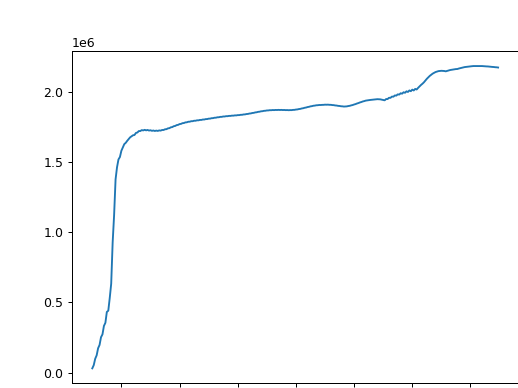

In [27]:
#plt.plot(time, dfVx['w1'])
dfMy.head(30)

#plt.plot(time, dfMy.iloc[:,0])
# plt.ylabel('Peak Base Shear (kip)')
# plt.xlabel('Frequency (Hz)')

plt.plot(f, peakMy)
# plt.ylabel('Peak Base Shear (kip)')
# plt.xlabel('Frequency (Hz)')